# Calibrating the model via FOPH data

## Imports and tools

In [1]:
%cd ..

/home/clement/epfl/sem_project/covid-19-switzerland


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sns.set_theme()

In [3]:
from model.age_groups_sir import AgeGroupsSIR

In [4]:
def savefig(filename):
    """
    Saves the last matplotlib figure in the figures/ repertory.
    """
    plt.tight_layout()
    plt.savefig('figures/' + filename)

We'll define a random number generator, which will be used for all stochastic tasks so that the results are reproducible.

In [5]:
rng = np.random.default_rng(seed=42)

## Loading the FOPH data
The data must first be decrypted using VeraCrypt.

In [6]:
foph_data = pd.read_csv('/media/veracrypt1/2021-10-22_10-03-52_BAGEPI-1086-cortes_study_data_cases.csv', sep=";")
foph_data.info()

<ipython-input-6-916b4b4b9459>:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  foph_data = pd.read_csv('/media/veracrypt1/2021-10-22_10-03-52_BAGEPI-1086-cortes_study_data_cases.csv', sep=";")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738598 entries, 0 to 738597
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   fall_id_hashd  738598 non-null  object 
 1   fall_dt        738598 non-null  object 
 2   altersjahr     738449 non-null  float64
 3   sex            738598 non-null  object 
 4   ktn            738598 non-null  object 
 5   gemeinde       720589 non-null  object 
 6   gemeinde_cd    720589 non-null  float64
 7   pt_d1_impf_dt  1997 non-null    object 
 8   pt_d2_impf_dt  1298 non-null    object 
 9   vacc_status    738598 non-null  object 
 10  case_death     15234 non-null   float64
 11  pttoddat       10487 non-null   object 
 12  pt_hospdatin   30886 non-null   object 
 13  datum_lm       736788 non-null  object 
dtypes: float64(3), object(11)
memory usage: 78.9+ MB


In [7]:
foph_data.head()

,fall_id_hashd,fall_dt,altersjahr,sex,ktn,gemeinde,gemeinde_cd,pt_d1_impf_dt,pt_d2_impf_dt,vacc_status,case_death,pttoddat,pt_hospdatin,datum_lm
0,3ede48f3-ff2d-4676-8a7c-517a320ff62e,2020-02-24,70.0,Männlich,TI,Lugano,5192.0,NaN,NaN,unknown,NaN,NaN,2020-02-24,2020-02-24
1,a5ab42b7-188d-437c-a7a8-cc573fd36488,2020-02-25,25.0,Männlich,AG,Möriken-Wildegg,4203.0,NaN,NaN,unknown,NaN,NaN,2020-02-25,2020-02-26
2,7206a959-7ea9-4d41-9bd8-5e246339269e,2020-02-26,2.0,Männlich,GR,NaN,NaN,NaN,NaN,unknown,NaN,NaN,2020-02-26,2020-02-26
3,183b5a64-34f2-4de5-9e49-3b29d604101f,2020-02-26,0.0,Männlich,GR,NaN,NaN,NaN,NaN,unknown,NaN,NaN,2020-02-26,2020-02-26
4,e1900c37-23f5-4e9e-a817-7e30513ae17a,2020-02-26,28.0,Männlich,GE,Genève,6621.0,NaN,NaN,unknown,NaN,NaN,NaN,2020-02-26


## Selecting columns

In [8]:
foph_data = foph_data.rename({'fall_id_hashd': 'hash_id', 'fall_dt': 'date', 'altersjahr': 'age',
                              'gemeinde': 'muni'}, axis=1)[['hash_id', 'date', 'age', 'ktn', 'muni']]
foph_data = foph_data.set_index('hash_id')
foph_data['date'] = pd.to_datetime(foph_data['date'])
foph_data.head()

,date,age,ktn,muni
hash_id,,,,
3ede48f3-ff2d-4676-8a7c-517a320ff62e,2020-02-24,70.0,TI,Lugano
a5ab42b7-188d-437c-a7a8-cc573fd36488,2020-02-25,25.0,AG,Möriken-Wildegg
7206a959-7ea9-4d41-9bd8-5e246339269e,2020-02-26,2.0,GR,NaN
183b5a64-34f2-4de5-9e49-3b29d604101f,2020-02-26,0.0,GR,NaN
e1900c37-23f5-4e9e-a817-7e30513ae17a,2020-02-26,28.0,GE,Genève


## Converting age to age groups
We'll need to know the age group in which each case falls into:

In [9]:
age_intervals = pd.DataFrame({'From': [0, 20, 65], 'To': [19, 64, 150], 'Group':['0-19', '19-64', '65-']})
# Converts to pandas IntervalIndex objects which will automatically be mapped to the age column
age_intervals = age_intervals.set_index(pd.IntervalIndex.from_arrays(age_intervals['From'], 
                                                             age_intervals['To'], closed='both'))['Group']
age_intervals

[0, 19]       0-19
[20, 64]     19-64
[65, 150]      65-
Name: Group, dtype: object

In [10]:
foph_data['age group'] = foph_data['age'].map(age_intervals)
foph_data.head()

,date,age,ktn,muni,age group
hash_id,,,,,
3ede48f3-ff2d-4676-8a7c-517a320ff62e,2020-02-24,70.0,TI,Lugano,65-
a5ab42b7-188d-437c-a7a8-cc573fd36488,2020-02-25,25.0,AG,Möriken-Wildegg,19-64
7206a959-7ea9-4d41-9bd8-5e246339269e,2020-02-26,2.0,GR,NaN,0-19
183b5a64-34f2-4de5-9e49-3b29d604101f,2020-02-26,0.0,GR,NaN,0-19
e1900c37-23f5-4e9e-a817-7e30513ae17a,2020-02-26,28.0,GE,Genève,19-64


## Inspecting epidemic waves

Text(0, 0.5, 'Monthly cases')

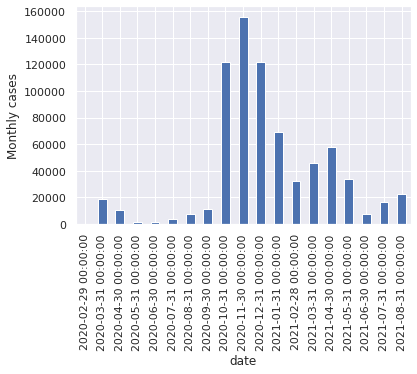

In [11]:
foph_data.resample('M', on='date').count()['age'].plot.bar()
plt.ylabel('Monthly cases')

Text(0, 0.5, 'Weekly cases')

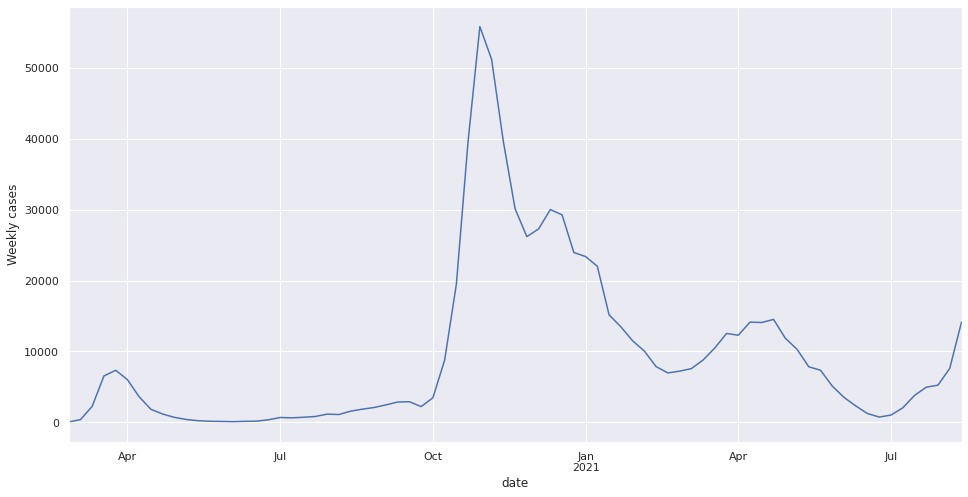

In [12]:
plt.figure(figsize=(16,8))
foph_data.resample('W', on="date").count()['age'].plot()
plt.ylabel('Weekly cases')

We can split the total timeline into three waves:

* 1st March 2020 - 4th April 2020
* 20th September 2020 - 15th March 2021
* 16th March 2021 - 25th June 2021

Let's have a look at each of those waves separately:

In [13]:
# Starting and ending dates of every wave. Each starting day should be a Monday,
# and each ending day should be a Sunday.
waves = [('2020-03-02', '2020-05-03'),
         ('2020-09-21', '2021-02-21'),
         ('2021-03-8', '2021-06-27')]

In [14]:
# Counts the weekly cases, with weeks starting on Mondays, separating the age groups
weekly_cases = foph_data.groupby('age group').resample(pd.offsets.Week(weekday=0), on="date").count().rename({'date': 'cases'}, axis=1)['cases'].reset_index()
# Pivots the table to have a column for each age group, and the date as the index
weekly_cases = weekly_cases.pivot(index='date', columns='age group', values='cases').fillna(0)
# Adds a last column containing the overall cases
weekly_cases['overall'] = weekly_cases.sum(axis=1)

In [15]:
weekly_cases.head()

age group,0-19,19-64,65-,overall
date,,,,
2020-02-24,0.0,0.0,1.0,1.0
2020-03-02,5.0,72.0,8.0,85.0
2020-03-09,15.0,395.0,128.0,538.0
2020-03-16,80.0,2264.0,785.0,3129.0
2020-03-23,237.0,4945.0,1760.0,6942.0


In [16]:
def plot_wave(start, end):
    """
    --start, end: dates given as datetime or str
    """
    wave_data = weekly_cases[(weekly_cases.index >= start) & (weekly_cases.index <= end)]
    sns.lineplot(data=wave_data)
    plt.ylabel('Weekly cases')

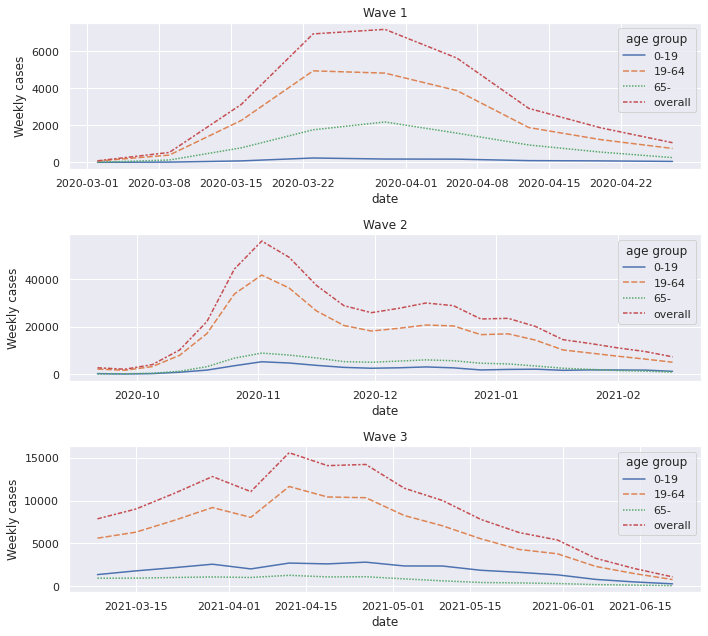

In [17]:
fig = plt.figure(figsize=(10, len(waves) * 3))
for wave, (start, end) in enumerate(waves):
    ax = fig.add_subplot(len(waves), 1, wave + 1)
    plot_wave(start, end)
    ax.title.set_text(f"Wave {wave + 1}")
savefig(f"waves.png")

## Model parameters and initial state

Let's first define the model's parameters:

In [37]:
# Defines the age groups, which will start at 0 and end at infinite.
age_groups = [19, 64]
# Recovery rate for each age group
gammas = np.array([0.2, 0.2, 0.2])
# File containing the contact matrices
contacts_csv = "data/contact_counts.csv"

We also need to define the population size. As the official figures for 2021 are not available yet, we'll use those from the Federal Statistical Office for 2020, for all three waves:  
https://www.bfs.admin.ch/bfs/en/home/statistics/population.html.  
We'll also use the age distribution from the same source:  
https://www.bfs.admin.ch/bfs/en/home/statistics/population/effectif-change/population.html

In [19]:
pop_size = 8670300

In [20]:
age_pop_sizes = np.array([0.2, 0.61, 0.19]) * pop_size

In [21]:
betas = {
        "work": 0.03,
        "education": 0.1,
        "leisure": 0.01,
        "service": 0.05,
        "home": 0.05,
        "shop": 0.03
}

We can now set the initial number of infections for each wave, based on the FOPH data:

In [22]:
waves_initial_infections = []
# For each wave, retrieves the number of cases of the first week
for wave, (start, end) in enumerate(waves):
    # We take the average over the first week to smoothen the result.
    # Otherwise, slightly changing the starting day of the wave could have a too
    # dramatical effect on the simulation.
    first_day_data = weekly_cases[weekly_cases.index == start] / 7
    waves_initial_infections.append(np.array(first_day_data.drop('overall', axis=1)))

In [24]:
waves_initial_infections

[array([[ 0.71428571, 10.28571429,  1.14285714]]),
 array([[ 48.        , 320.57142857,  31.        ]]),
 array([[191.57142857, 799.85714286, 131.28571429]])]

### Selecting a wave
From now on, we'll work with a single wave to calibrate the model.

In [31]:
# Choose: 1, 2 or 3
wave = 1
initial_infections = waves_initial_infections[wave]

### Initial state
The state is represented by a matrix of shape $(N_{age\ groups}, 3)$ whose columns are the number of Susceptible, Infectious and Recovered people respectively.  
We'll consider the number of Recovered people to be 0 at the beginning of the simulation. This considers that the fraction of the population who's immunized to the disease can be neglected.

We'll now define a function which yields a slightly altered initial state. The real number of initial infections is either slighly increased or decreased (for example, 80% to 120%).

In [34]:
def initial_state_func():
    initial_state = np.zeros((3, 3))
    # Defines the variation of the number of initial infectious
    variation = rng.random(3) * 0.4 + 0.8
    # Infectious people
    initial_state[:, 1] = initial_infections * variation
    # Susceptible
    initial_state[:, 0] = age_pop_sizes - initial_state[:, 1]
    return initial_state

In [36]:
print(initial_state_func().astype(int))

[[1734006      53       0]
 [5288525     357       0]
 [1647330      26       0]]


## Model run

In [38]:
model = AgeGroupsSIR({'age_groups': age_groups,
                      'N': pop_size,
                      'gammas': gammas})
model.load_force_of_infection(contacts_csv, betas)

Let's define the simulation parameters:

In [39]:
# Duration of the simulation
days = 60
# timestep of the simulation
day_eval_freq = 4
# Number of runs to estimate the uncertainty
runs = 10

In [42]:
results = model.solve(days, initial_state_func, day_eval_freq=day_eval_freq, runs=runs)

<ipython-input-43-97548921259f>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


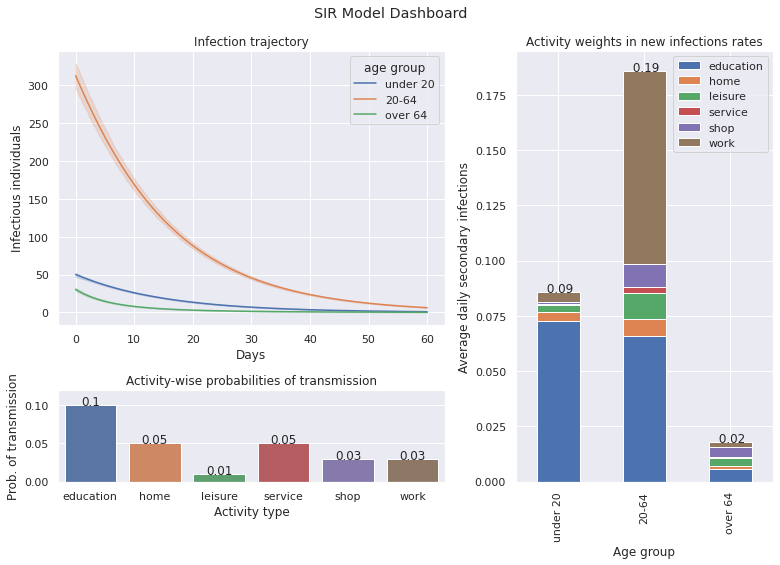

In [43]:
fig = model.dashboard()
savefig('dashboard.png')
fig.show()